In [ ]:
!pip install -q h2o pandas matplotlib scikit-learn shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 5.2 MB/s eta 0:00:00


In [ ]:
# === Cell 2: Initialize H2O Cluster ===
import h2o
h2o.init(max_mem_size_GB=8)
h2o.no_progress()  # disable H2O progress bars

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,16 mins 33 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_unknownUser_lc3ou9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.612 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# === Cell 3: Load Preprocessed Data ===
import pandas as pd
train_df = pd.read_csv('/content/train_preprocessed.csv')
test_df  = pd.read_csv('/content/test_preprocessed.csv')

hf_train = h2o.H2OFrame(train_df)
hf_test  = h2o.H2OFrame(test_df)
hf_train['readmit_30_days'] = hf_train['readmit_30_days'].asfactor()
hf_test ['readmit_30_days'] = hf_test ['readmit_30_days'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# === Cell 4: Split into Train/Validation ===
# We already have a separate test set hf_test
train, valid = hf_train.split_frame(ratios=[0.8], seed=42)
print(f"Train: {train.nrow}, Valid: {valid.nrow}, Test: {hf_test.nrow}")

Train: 98744, Valid: 24748, Test: 52926


In [ ]:
# === Cell 5: Define Features & Target ===
features = [c for c in train.columns if c.startswith('PC')]
target   = 'readmit_30_days'

Saved GLM at /content/h2o_models/GLM_model_python_1746618049643_16
GLM Train AUC: 0.6077864136802844
              precision    recall  f1-score   support

           0       0.77      0.02      0.04     49174
           1       0.51      0.99      0.67     49570

    accuracy                           0.51     98744
   macro avg       0.64      0.51      0.35     98744
weighted avg       0.64      0.51      0.36     98744



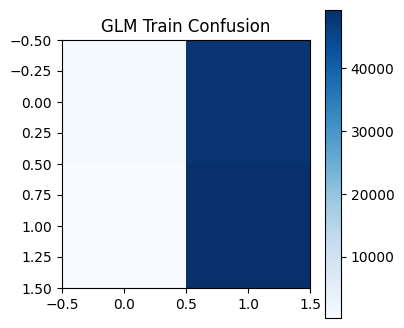

GLM Test AUC: 0.6062752584584998
              precision    recall  f1-score   support

           0       0.79      0.02      0.04     26425
           1       0.51      0.99      0.67     26501

    accuracy                           0.51     52926
   macro avg       0.65      0.51      0.36     52926
weighted avg       0.65      0.51      0.36     52926



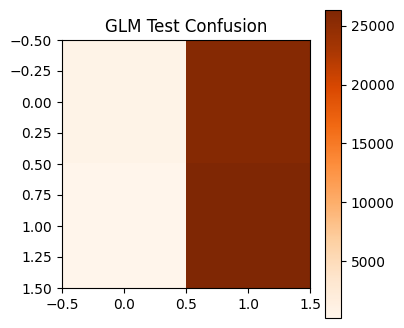

In [ ]:
# === Cell 6: GLM Training, Save, Metrics, Confusion ===
from h2o.estimators import H2OGeneralizedLinearEstimator
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Train GLM
glm = H2OGeneralizedLinearEstimator(family='binomial', lambda_=0.1, alpha=0.5, seed=42)
glm.train(x=features, y=target, training_frame=train, validation_frame=valid)
# Save GLM
glm_path = h2o.save_model(glm, path='/content/h2o_models', force=True)
print("Saved GLM at", glm_path)

# Convert frames to pandas for metrics
df_train = train.as_data_frame(use_multi_thread=True)
df_test  = hf_test.as_data_frame(use_multi_thread=True)
# Predictions
pred_train = glm.predict(train).as_data_frame(use_multi_thread=True)
pred_test  = glm.predict(hf_test).as_data_frame(use_multi_thread=True)
# True labels
y_train = df_train[target].astype(int).values
y_test  = df_test[target].astype(int).values

# Training metrics
fpr, tpr, _ = roc_curve(y_train, pred_train['p1'])
print("GLM Train AUC:", auc(fpr,tpr))
print(classification_report(y_train, pred_train['predict'].astype(int)))
cm = confusion_matrix(y_train, pred_train['predict'].astype(int))
plt.figure(figsize=(4,4)); plt.title('GLM Train Confusion'); plt.imshow(cm, cmap='Blues'); plt.colorbar(); plt.show()

# Testing metrics
fpr, tpr, _ = roc_curve(y_test, pred_test['p1'])
print("GLM Test AUC:", auc(fpr,tpr))
print(classification_report(y_test, pred_test['predict'].astype(int)))
cm = confusion_matrix(y_test, pred_test['predict'].astype(int))
plt.figure(figsize=(4,4)); plt.title('GLM Test Confusion'); plt.imshow(cm, cmap='Oranges'); plt.colorbar(); plt.show()

/usr/local/lib/python3.11/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


Saved GBM at /content/h2o_models/GBM_model_python_1746618049643_19
GBM Train AUC: 0.7426348535010394
              precision    recall  f1-score   support

           0       0.80      0.38      0.51     49174
           1       0.60      0.91      0.72     49570

    accuracy                           0.64     98744
   macro avg       0.70      0.64      0.62     98744
weighted avg       0.70      0.64      0.62     98744



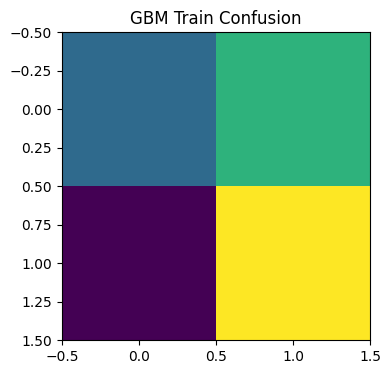

GBM Test AUC: 0.7089066002293268
              precision    recall  f1-score   support

           0       0.77      0.35      0.48     26425
           1       0.58      0.89      0.70     26501

    accuracy                           0.62     52926
   macro avg       0.67      0.62      0.59     52926
weighted avg       0.67      0.62      0.59     52926



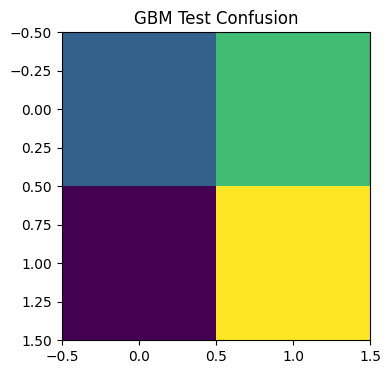

In [ ]:
# === Cell 7: GBM Training, Save, Metrics, Confusion ===
from h2o.estimators import H2OGradientBoostingEstimator
# Train GBM
gbm = H2OGradientBoostingEstimator(
    ntrees=200, max_depth=6, learn_rate=0.05,
    stopping_rounds=20, stopping_metric='AUC', stopping_tolerance=1e-3, seed=42
)
gbm.train(x=features, y=target, training_frame=train, validation_frame=valid)
gbm_path = h2o.save_model(gbm, path='/content/h2o_models', force=True)
print("Saved GBM at", gbm_path)

# Metrics & confusion
pred_train = gbm.predict(train).as_data_frame(use_multi_thread=True)
pred_test  = gbm.predict(hf_test).as_data_frame(use_multi_thread=True)
# Train
fpr, tpr, _ = roc_curve(y_train, pred_train['p1'])
print("GBM Train AUC:", auc(fpr,tpr))
print(classification_report(y_train, pred_train['predict'].astype(int)))
cm = confusion_matrix(y_train, pred_train['predict'].astype(int))
plt.figure(figsize=(4,4)); plt.title('GBM Train Confusion'); plt.imshow(cm); plt.show()
# Test
fpr, tpr, _ = roc_curve(y_test, pred_test['p1'])
print("GBM Test AUC:", auc(fpr,tpr))
print(classification_report(y_test, pred_test['predict'].astype(int)))
cm = confusion_matrix(y_test, pred_test['predict'].astype(int))
plt.figure(figsize=(4,4)); plt.title('GBM Test Confusion'); plt.imshow(cm); plt.show()

Saved RF at /content/h2o_models/DRF_model_python_1746618049643_54
RF Train AUC: 0.9990184960653896
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     49174
           1       0.99      0.97      0.98     49570

    accuracy                           0.98     98744
   macro avg       0.98      0.98      0.98     98744
weighted avg       0.98      0.98      0.98     98744



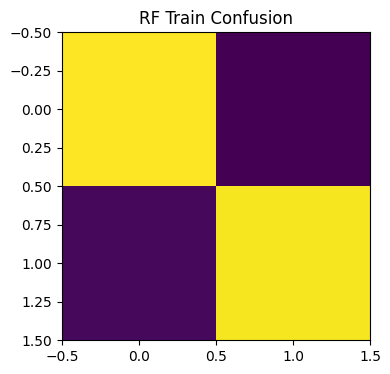

RF Test AUC: 0.9842566851960425
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     26425
           1       0.94      0.94      0.94     26501

    accuracy                           0.94     52926
   macro avg       0.94      0.94      0.94     52926
weighted avg       0.94      0.94      0.94     52926



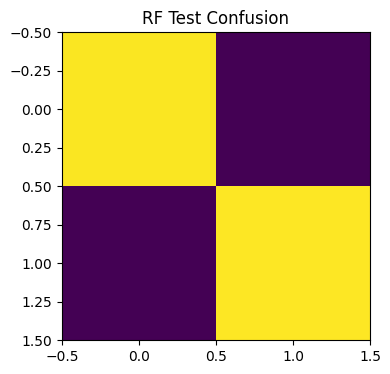

In [ ]:
# === Cell 8: DRF Training, Save, Metrics, Confusion ===
from h2o.estimators import H2ORandomForestEstimator
# Train RF
rf = H2ORandomForestEstimator(ntrees=200, max_depth=20, seed=42)
rf.train(x=features, y=target, training_frame=train)
rf_path = h2o.save_model(rf, path='/content/h2o_models', force=True)
print("Saved RF at", rf_path)
# Metrics & confusion
pred_train = rf.predict(train).as_data_frame(use_multi_thread=True)
pred_test  = rf.predict(hf_test).as_data_frame(use_multi_thread=True)
fpr, tpr, _ = roc_curve(y_train, pred_train['p1'])
print("RF Train AUC:", auc(fpr,tpr))
print(classification_report(y_train, pred_train['predict'].astype(int)))
cm = confusion_matrix(y_train, pred_train['predict'].astype(int))
plt.figure(figsize=(4,4)); plt.title('RF Train Confusion'); plt.imshow(cm); plt.show()
fpr, tpr, _ = roc_curve(y_test, pred_test['p1'])
print("RF Test AUC:", auc(fpr,tpr))
print(classification_report(y_test, pred_test['predict'].astype(int)))
cm = confusion_matrix(y_test, pred_test['predict'].astype(int))
plt.figure(figsize=(4,4)); plt.title('RF Test Confusion'); plt.imshow(cm); plt.show()

Saved DL at /content/h2o_models/DeepLearning_model_python_1746618049643_79
DL Train AUC: 0.7002381217888982
              precision    recall  f1-score   support

           0       0.77      0.27      0.40     49174
           1       0.56      0.92      0.70     49570

    accuracy                           0.60     98744
   macro avg       0.67      0.60      0.55     98744
weighted avg       0.67      0.60      0.55     98744



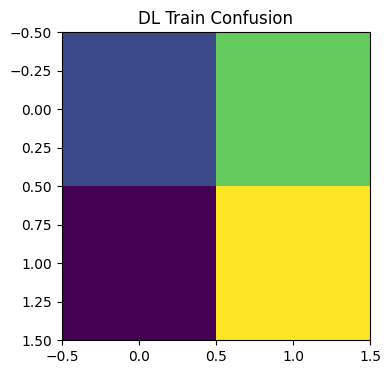

DL Test AUC: 0.6669557640084054
              precision    recall  f1-score   support

           0       0.73      0.25      0.37     26425
           1       0.55      0.91      0.68     26501

    accuracy                           0.58     52926
   macro avg       0.64      0.58      0.53     52926
weighted avg       0.64      0.58      0.53     52926



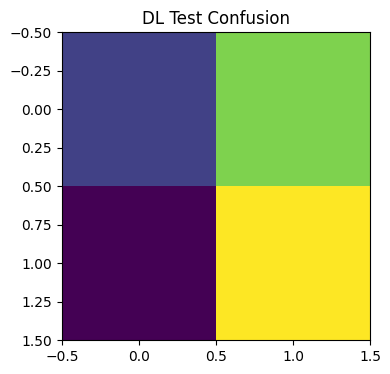

In [ ]:
# === Cell 9: DL Training, Save, Metrics, Confusion ===
from h2o.estimators import H2ODeepLearningEstimator
# Train DL
dl = H2ODeepLearningEstimator(hidden=[50,50], epochs=20, activation='Rectifier', seed=42)
dl.train(x=features, y=target, training_frame=train)
dl_path = h2o.save_model(dl, path='/content/h2o_models', force=True)
print("Saved DL at", dl_path)
# Metrics & confusion
pred_train = dl.predict(train).as_data_frame(use_multi_thread=True)
pred_test  = dl.predict(hf_test).as_data_frame(use_multi_thread=True)
fpr, tpr, _ = roc_curve(y_train, pred_train['p1'])
print("DL Train AUC:", auc(fpr,tpr))
print(classification_report(y_train, pred_train['predict'].astype(int)))
cm = confusion_matrix(y_train, pred_train['predict'].astype(int))
plt.figure(figsize=(4,4)); plt.title('DL Train Confusion'); plt.imshow(cm); plt.show()
fpr, tpr, _ = roc_curve(y_test, pred_test['p1'])
print("DL Test AUC:", auc(fpr,tpr))
print(classification_report(y_test, pred_test['predict'].astype(int)))
cm = confusion_matrix(y_test, pred_test['predict'].astype(int))
plt.figure(figsize=(4,4)); plt.title('DL Test Confusion'); plt.imshow(cm); plt.show()

In [21]:
# === Cell 10: Bundle & Download All Saved Models ===
import shutil
from google.colab import files

# Zip the models directory
target_dir = '/content/h2o_models'
archive_name = 'h2o_models_archive'
shutil.make_archive(archive_name, 'zip', target_dir)
# Download the ZIP file
files.download(f'{archive_name}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>